In [1]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

In [3]:
hgg = ak.from_parquet('nanless_flat400.parquet')
qcd = ak.from_parquet('stitched.parquet')

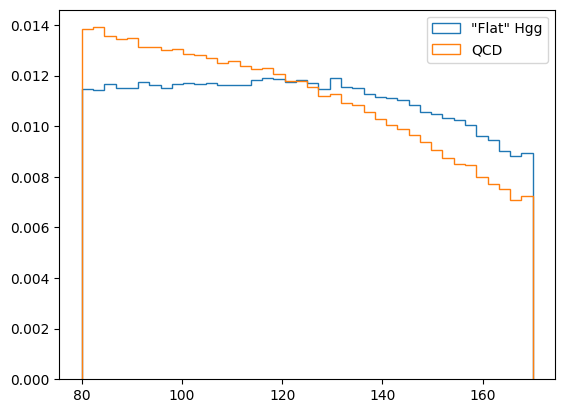

In [4]:
plt.hist(hgg.goodjets.msoftdrop, bins=40, histtype='step', density=True, label='"Flat" Hgg')
# plt.hist(qcd.goodjets.msoftdrop, bins=40, histtype='step', density=True, label='QCD 470to600')
plt.hist(qcd.msoftdrop, bins=40, histtype='step', density=True, label='QCD')
plt.legend()
plt.show()

In [27]:
def create_removal_mask_to_match_large_array(small_array, large_array, num_bins=1000):
    # Ensure inputs are NumPy arrays
    small_array = np.asarray(small_array)
    large_array = np.asarray(large_array)
    
    # Compute histograms for both arrays using the same bin edges
    large_hist, bin_edges = np.histogram(large_array, bins=num_bins, density=True)
    small_hist, _ = np.histogram(small_array, bins=bin_edges, density=True)
    
    # Create a mask for the small array to keep or remove values
    mask = np.ones(len(small_array), dtype=bool)
    
    # Calculate the actual counts (not density) for each bin in the small array
    small_counts, _ = np.histogram(small_array, bins=bin_edges)
    
    # Ensure the histogram arrays are NumPy arrays
    large_hist = np.asarray(large_hist)
    small_hist = np.asarray(small_hist)
    
    # Compute the ratio of large to small array densities in each bin
    with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
        density_ratios = np.divide(large_hist, small_hist, out=np.zeros_like(large_hist), where=small_hist > 0)
        density_ratios = np.clip(density_ratios, 0, 1)  # Ensure no negative values
    
    # For each bin, randomly remove values if needed
    for i in range(num_bins):
        # Find indices of small_array values that fall within the current bin
        bin_mask = (small_array >= bin_edges[i]) & (small_array < bin_edges[i+1])
        bin_indices = np.where(bin_mask)[0]
        
        # Number of values currently in the bin
        bin_count = len(bin_indices)
        
        # Number of values to keep based on the density ratio
        num_to_keep = int(density_ratios[i] * bin_count)
        
        # If we need to remove values, randomly select values to remove
        if num_to_keep < bin_count:
            remove_indices = np.random.choice(bin_indices, size=(bin_count - num_to_keep), replace=False)
            mask[remove_indices] = False  # Mark these values to be removed
    
    return mask

In [28]:
def iterative_matching_with_master_mask(small_array, large_array, num_bins=1000, iterations=5):
    # Initialize the master mask as all True (keep all values initially)
    master_mask = np.ones(len(small_array), dtype=bool)
    
    current_array = small_array.copy()
    
    for _ in range(iterations):
        # Create a mask for the current iteration
        iteration_mask = create_removal_mask_to_match_large_array(current_array, large_array, num_bins)
        
        # Apply the iteration mask to the current array
        current_array = current_array[iteration_mask]
        
        # Update the master mask by combining it with the iteration mask
        # We apply False to the master mask wherever the iteration mask is False
        master_mask[master_mask] = iteration_mask  # Only update positions where master_mask is still True
    
    return master_mask

In [35]:
mask = iterative_matching_with_master_mask(hgg.goodjets.msoftdrop.to_numpy(), qcd.msoftdrop.to_numpy(), num_bins=1000, iterations=25)

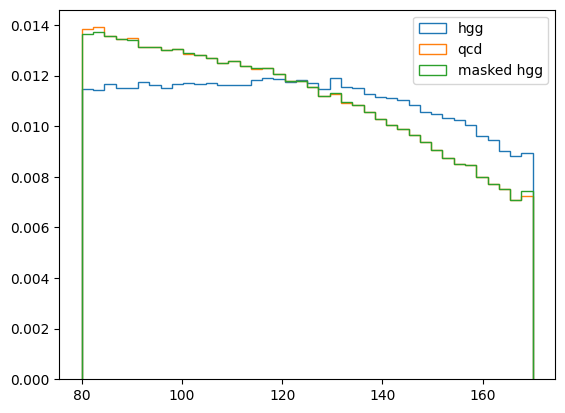

In [36]:
plt.hist(hgg.goodjets.msoftdrop, bins=40, histtype='step', density=True, label='hgg')
plt.hist(qcd.msoftdrop, bins=40, histtype='step', density=True, label='qcd')
plt.hist(hgg.goodjets.msoftdrop[mask], bins=40, histtype='step', density=True, label='masked hgg')
plt.legend()
plt.show()

In [37]:
len(hgg[mask])

648671

In [38]:
ak.to_parquet(hgg[mask], 'nanless_sculpted_hgg.parquet')

  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 339
  num_rows: 648671
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [31]:
mask = iterative_matching_with_master_mask(qcd.msoftdrop.to_numpy(), hgg.goodjets.msoftdrop.to_numpy(), num_bins=1000, iterations=25)

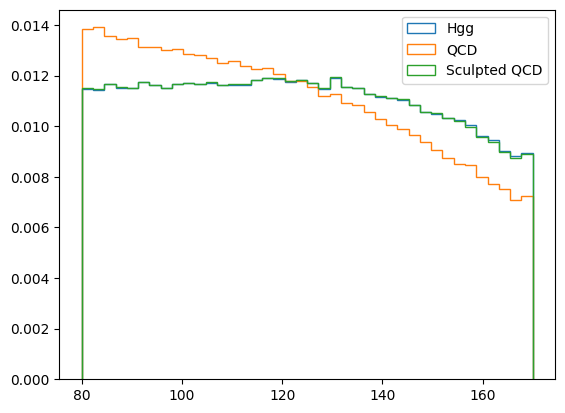

In [32]:
plt.hist(hgg.goodjets.msoftdrop, bins=40, histtype='step', density=True, label='Hgg')
# plt.hist(qcd.goodjets.msoftdrop, bins=40, histtype='step', density=True, label='QCD')
# plt.hist(qcd.goodjets.msoftdrop[mask], bins=40, histtype='step', density=True, label='Sculpted QCD')
plt.hist(qcd.msoftdrop, bins=40, histtype='step', density=True, label='QCD')
plt.hist(qcd.msoftdrop[mask], bins=40, histtype='step', density=True, label='Sculpted QCD')
plt.legend()
plt.show()

In [33]:
len(qcd[mask])

653742

In [34]:
ak.to_parquet(qcd[mask], 'stitched_sculpted_qcd.parquet')

  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 339
  num_rows: 653742
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [39]:
import numpy as np
import awkward as ak

def create_balancing_mask(data, bins):
    """
    Create a mask for the input dataset such that the resulting histogram is
    as close to perfectly flat as possible, independent of the number of bins.

    Parameters:
        data (array-like): The input dataset (1D array or awkward array).
        bins (array-like or int): Bin edges or number of bins for the histogram.

    Returns:
        numpy.ndarray: A boolean mask of the same length as `data`.
    """
    # Ensure data is converted to a flat NumPy array
    data = ak.to_numpy(data)

    # Compute histogram and bin edges
    hist, bin_edges = np.histogram(data, bins=bins)

    # Determine the target bin height
    target_height = hist.min()

    # Initialize an empty mask
    mask = np.zeros_like(data, dtype=bool)

    # Create an index list for balanced sampling
    indices_to_include = []

    for i in range(len(bin_edges) - 1):
        # Get indices of elements in this bin
        bin_mask = (data >= bin_edges[i]) & (data < bin_edges[i + 1])
        selected_indices = np.where(bin_mask)[0]

        # Select exactly `target_height` points from this bin
        if len(selected_indices) > target_height:
            selected_indices = np.random.choice(
                selected_indices, size=target_height, replace=False
            )
        indices_to_include.extend(selected_indices)

    # Ensure a perfect flat distribution
    # Shuffle all included indices for uniformity
    np.random.shuffle(indices_to_include)

    # Update the mask
    mask[indices_to_include] = True

    return mask

In [40]:
hgg_mask = create_balancing_mask(hgg.goodjets.msoftdrop.to_numpy(), 40)
qcd_mask = create_balancing_mask(qcd.msoftdrop.to_numpy(), 40)

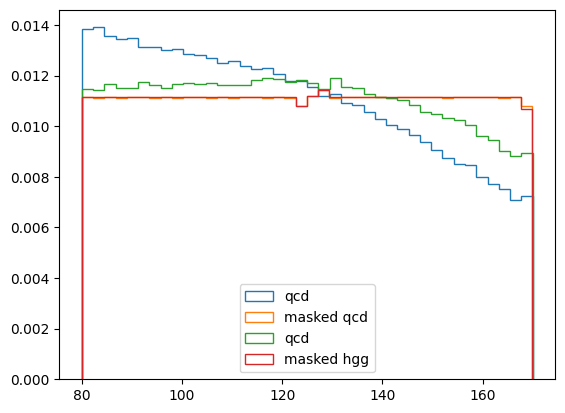

In [41]:
plt.hist(qcd.msoftdrop, bins=40, histtype='step', density=True, label='qcd')
plt.hist(qcd.msoftdrop[qcd_mask], bins=40, histtype='step', density=True, label='masked qcd')
plt.hist(hgg.goodjets.msoftdrop, bins=40, histtype='step', density=True, label='qcd')
plt.hist(hgg.goodjets.msoftdrop[hgg_mask], bins=40, histtype='step', density=True, label='masked hgg')
plt.legend()
plt.show()

In [43]:
len(qcd[qcd_mask]), len(hgg[hgg_mask])

(525221, 631491)

In [44]:
ak.to_parquet(qcd[qcd_mask], 'flat_qcd.parquet')

  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 339
  num_rows: 525221
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [45]:
ak.to_parquet(hgg[hgg_mask], 'flat_hgg.parquet')

  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 339
  num_rows: 631491
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0